In [1]:
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

#create the list of dictinary formatted strings by extracting data item
#from twitter API scrape
#files = ['twtgun3.24.1.txt', 'twtgun3.24.2.txt','twtgun3.24.3.txt', 'twtgun3.24.4.txt']

group = []
for i in range(1,11):
   
    with open('twtgun3.24.' + str(i) + '.txt') as fhand:
        for item in fhand:
            dic = {}
            x = re.findall("^{'created_at': \'(.*?)\'", item)
            if len(x) > 0:
                dic["created_at"] = str(x[0])
            else:
                dic["created_at"] = None
            y = re.findall("{'full_text': \'(.*?)\'", item)
            if len(y) > 0:
                dic["full_text"] = str(y[0])
            else:
                dic["full_text"] = None
            z = re.findall(" 'text': \'(.*?)\'", item)
            if len(z) > 0:
                dic["text"] = str(z[0])
            else:
                dic["text"] = None
            a = re.findall("\'location\': \'(.*?)\'", item)
            if len(a) > 0:
                dic["location"] = str(a[0])
            else:
                dic["location"] = None
            b = re.findall("\'time_zone\': \'(.*?)\'", item)
            if len(b) > 0:
                dic["time_zone"] = str(b[0])
            else:
                dic["time_zone"] = None
            group.append(dic)

    fhand.close()

#convert the list into json object

with open('data.json', 'w') as fp:
    json.dump(group, fp)

# convert json file into pandas DataFrame
df = pd.read_json('data.json')

In [2]:
df.sample(5)  # To check the data

,created_at,full_text,location,text,time_zone
17675,2018-03-24 21:29:00,"""One of my best friends was killed in gun viol...","Tucson, Az.","RT @SilverAdie: ""One of my best friends was ki...",Pacific Time (US & Canada)
7226,2018-03-24 20:34:41,"Today and every day, listen to young people. #...",None,"RT @ladygaga: Today and every day, listen to y...",Quito
3092,2018-03-24 20:12:11,None,"Boston, MA",RT @DENewman: Thanks @joekennedy for leading t...,Eastern Time (US & Canada)
16185,2018-03-24 21:19:57,None,None,RT @fritchee: #guncontrol https://t.co/iBWf7JXPWB,None
9249,2018-03-24 20:42:01,Today was a day of hope and inspiration to con...,"La Crosse, WI",RT @kruegermt: Today was a day of hope and ins...,Central Time (US & Canada)


In [3]:
df2 = df.reindex(columns = ['created_at','location','time_zone','text','full_text'])
pd.options.display.max_rows=10

In [4]:
df2['text'] = df2['text'].replace(r'\\n', '', regex=True).str.lower()
df2['text'] = df2['text'].str.strip()
df2['full_text'] = df2['full_text'].replace(r'\\n', '', regex=True).str.lower()
df2['full_text'] = df2['full_text'].str.strip()

In [5]:
print(df2.head())    # To check the data

           created_at                location                   time_zone  \
0                 NaT                     CNY                        None   
1 2018-03-24 17:23:06  Bearvana, #OpFuckBaba   Pacific Time (US & Canada)   
2 2018-03-24 17:23:06     South West, England                        None   
3 2018-03-24 17:23:07                    None                        None   
4 2018-03-24 17:23:08            Arizona, USA  Pacific Time (US & Canada)   

                                                text  \
0                #guncontrol https://t.co/oc8a0uwgco   
1       rt @redpainter1: hey @dloeschhear that? that   
2                                                      
3  rt @we_patriot: here it is in black and white-...   
4  rt @madriannorman: #marchforourlives #2ndamend...   

                                           full_text  
0                                               None  
1                        hey @dloeschhear that? that  
2                                  

In [6]:
#df2['full_text'].str.findall('\\n') just to make sure no data will be found

In [7]:
#make copy of df2 and name it df3
df3 = df2

In [8]:
#Take 'full_text' when available, otherwise take 'text'
df3['tweet'] = df3['full_text'].where(pd.notna(df3['full_text']), other = df3['text'])
#Use time_zone for proxy of location when location data is missing
df3['location_'] = df3['location'].where(pd.notna(df3['location']), other = df3['time_zone'])

In [9]:
pd.isna(df3['tweet']).sum()  # Check how many 'tweet' observations are missing

3546

In [10]:
#drop columns 'text' & 'full_text', 'location' & 'time_zone'
df3 = df3.drop(['text', 'full_text', 'location', 'time_zone'], axis=1)
#rename 'location_' column to 'location' then reindex dataframe 
df3.rename(columns = {'location_':'location'}, inplace = True)
df3.reindex(columns = ['created_at','location','tweet'])

#drop rows where all columns are NaN
df3 = df3.dropna(how='all')

In [11]:
#Extract hashtag from 'tweet' and create a new cloumn 'hashtag'
df3['hashtag'] = df3['tweet'].str.findall(r'#.*?\s')  # .findall returns list which causes issues later

In [12]:
df3 = df3.reindex(columns = ['created_at','location','tweet','hashtag'])
print(df3.sample(5))

               created_at                        location  \
12523 2018-03-24 20:58:10  #WhatYouDoMatters #NeverForget   
28465 2018-03-24 22:52:15      Pacific Time (US & Canada)   
21427 2018-03-24 21:54:28                   Corvallis, OR   
24334 2018-03-24 22:14:08                  Burlington, VT   
15734 2018-03-24 21:17:19                    Portland, OR   

                                                   tweet  \
12523  #destroythenra if you’re a @nra member your co...   
28465  rt @alfredoflores: #marchforourlives #enough h...   
21427  fight for our lives march portland, or. #iwill...   
24334                                               None   
15734  three #marchforourlives signs inside of portla...   

                                                 hashtag  
12523  [#destroythenra , #gunsafety? , #marchforourli...  
28465                     [#marchforourlives , #enough ]  
21427  [#iwillmarch , #marchforourlivesdc , #endgunvi...  
24334                               

In [13]:
# Convert 'created_at' time data into US & Canada Eastern Time and adjust for day light saving

In [14]:
# Convert'created_at' time data rounding to nearest minute 
df3['created_at'] = df3['created_at'].apply(lambda x: x.round('min'))

In [15]:
# Check how many tweets creatd every minute during the data collection period
df3.groupby('created_at').count()['tweet']

created_at
2018-03-24 17:23:00     32
2018-03-24 17:24:00     59
2018-03-24 17:25:00     65
2018-03-24 17:26:00     82
2018-03-24 17:27:00     56
                      ... 
2018-03-25 00:51:00    113
2018-03-25 00:52:00    143
2018-03-25 00:53:00    117
2018-03-25 00:54:00    142
2018-03-25 00:55:00     74
Name: tweet, Length: 303, dtype: int64

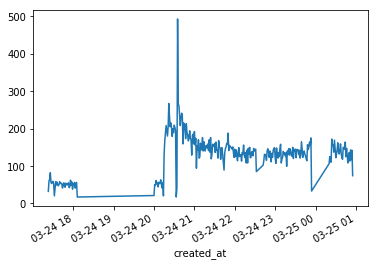

In [16]:
df3.groupby('created_at').count()['tweet'].plot()
#Timestamp is in Coordinated Universal Time (UTC), which is 5 hour earlier than EST.
#Number of tweets peaked around 3:30pm (EST) in the graph below. We'll adjust time-zone later.

In [17]:
# As the next step, use regular expression to tokenize tweets
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

In [18]:
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [19]:
# Test run using only one tweet
tweet = df3['tweet'][10]
print(preprocess(tweet))   #success!

['rt', '@alessiacara', ':', 'https://t.co/sofihs4oru', 'please', 'click', 'and', 'read', 'up', 'on', 'why', 'this', 'is', 'so', 'important', '.', 'i', 'hope', 'you', 'sign', '.', '#marchforourlives', '#guncontr', '…']


In [20]:
# Create a new dataframe by dropping rows with NA data
df4 = df3.dropna(axis=0, inplace=False)
df4.head()

,created_at,location,tweet,hashtag
1,2018-03-24 17:23:00,"Bearvana, #OpFuckBaba",hey @dloeschhear that? that,[]
2,2018-03-24 17:23:00,"South West, England",,[]
4,2018-03-24 17:23:00,"Arizona, USA",rt @madriannorman: #marchforourlives #2ndamend...,"[#marchforourlives , #2ndamendment , #nra , #n..."
5,2018-03-24 17:23:00,"Arizona, USA",rt @madriannorman: #marchforourlives #2ndamend...,"[#marchforourlives , #2ndamendment , #nra , #n..."
6,2018-03-24 17:23:00,985✈️DMV,meddling globalist george soros named as the p...,"[#georgesoros , #guncontrol ]"


In [ ]:
# Tokenize tweet data in the dataframe
df4.loc[:,'preprocess_tweet'] = df4.loc[:,'tweet'].apply(lambda x : preprocess(x))
df4.head()

In [22]:
#from nltk download premade stopwords list
from nltk.corpus import stopwords
import string

punc = list(string.punctuation)
stop = stopwords.words('english') + punc + ['rt', 'via', '’', 'amp']

In [23]:
#Test run using only one tweet
terms_nostop = [term for term in preprocess(tweet) if term not in stop]  #success!

In [24]:
# There are 37487 rows in df4. for each item (list) in the 'preprocess_tweet' column, check if it's non-empty, then 
# remove stop words from the item and append it to the longer 'items' list. Since the data is large, 
# increase data rate by jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

items = []
for item in df4['preprocess_tweet']:
    if len(item) !=0:
        for i in item:
            if i not in stop and not i.startswith(('#', '@')):
                items.append(i.strip())
            else:
                continue  
    else:
        continue
        
print(items[:10])

['hey', 'https://t.co/tqe7k0yvgj', 'https://t.co/tqe7k0yvgj', 'meddling', 'globalist', 'george', 'soros', 'named', 'puppet', 'master']


In [25]:
# Listing top 30 most common words in tweets during the data collection period
import operator
from collections import Counter

count_all = Counter()
count_all.update(items)
print(count_all.most_common(30))    

[('today', 8636), ('pier', 5412), ('gun', 5213), ('march', 5103), ('people', 4938), ('day', 4236), ('every', 4047), ('thousands', 3496), ('common', 3483), ('sense', 3377), ('speaking', 3302), ('young', 3246), ('demand', 3228), ('guns', 3149), ('americans', 2937), ('legislation', 2841), ('south', 2734), ('prevention', 2734), ('view', 2723), ('overflowed', 2712), ('bay', 2711), ('https://t.co/aeo98ltgzf', 2704), ('lives', 2650), ('students', 2644), ('…', 2624), ('school', 2507), ('youth', 2489), ('stories', 2118), ('kids', 2069), ('️', 2030)]


In [26]:
# Creating the list of hashtags tweeted during the data colletion period
hashlist = []
for item in df4['hashtag']:
    if len(item) !=0:
        for i in item:
            if i.startswith('#'):
                hashlist.append(i.strip())
            else:
                continue  
    else:
        continue
        
print(hashlist[:10])

['#marchforourlives', '#2ndamendment', '#nra', '#nraboycott', '#2a', '#gunreformnow', '#gunviolence', '#marchforourlives', '#2ndamendment', '#nra']


In [27]:
# Listing top 30 most popular hash tags during the data collection period

count_hash = Counter()
count_hash.update(hashlist)
print(count_hash.most_common(30))

[('#marchforourlives', 21017), ('#enough', 15252), ('#neveragain', 6940), ('#guncontrol', 6296), ('#gunviolence', 5710), ('#hermosabeach', 2706), ('#guncontrol.', 2334), ('#gunreformnow', 1939), ('#gunreform', 1473), ('#guncontrolnow', 1416), ('#2a', 1267), ('#enoughisenough', 1249), ('#parkland', 1122), ('#march4ourlives', 1104), ('#guncontolnow', 1080), ('#notonemore', 1018), ('#nra', 969), ('#gunsense', 907), ('#resist', 876), ('#momsdemandaction', 830), ('#trump', 809), ('#nrakillskids', 709), ('#gunsensenow', 703), ('#wecallbs', 632), ('#impeachtrump', 595), ('#endgunviolence', 578), ('#theresistance', 578), ('#maga', 562), ('#blacklivesmatter', 520), ('#votethemout', 517)]


In [28]:
# to remove emojis from tokens, compile emoji patterns to be removed

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F500"  # symbols & pictographs
        u"\U0001F520-\U0001F52F"
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)                          
        u"\U0001F910-\U0001F96B" 
        u"\U0001F52B"
        u"\U0001F5E3"             # speech
        u"\U0001F5F3"             # vote 
        u"\U0001F91B-\U0001F939"                   
        u"\U0001F191-\U0001F19A"
        u"\U0001F595"
                             "]+", flags = re.UNICODE)

In [29]:
# Remove emojis from the list of tokenized words
items_noemoji = []
for item in items:
    i = emoji_pattern.sub(r'', item)
    items_noemoji.append(i)
    
print(items_noemoji[:10])

['hey', 'https://t.co/tqe7k0yvgj', 'https://t.co/tqe7k0yvgj', 'meddling', 'globalist', 'george', 'soros', 'named', 'puppet', 'master']


In [30]:
# Listing top 30 word-pairs tweeted together during the data collection periods
from nltk import bigrams

terms_bigram = list(bigrams(items_noemoji))
count_bigram = Counter()
count_bigram.update(terms_bigram)
print(count_bigram.most_common(30))

[(('', ''), 4199), (('every', 'day'), 3512), (('common', 'sense'), 3358), (('thousands', 'americans'), 2715), (('prevention', 'legislation'), 2712), (('south', 'bay'), 2709), (('demand', 'common'), 2709), (('sense', 'prevention'), 2707), (('view', 'speaking'), 2706), (('speaking', 'south'), 2706), (('bay', 'pier'), 2706), (('pier', 'thousands'), 2706), (('americans', 'overflowed'), 2706), (('overflowed', 'pier'), 2706), (('pier', 'demand'), 2706), (('legislation', 'https://t.co/aeo98ltgzf'), 2704), (('young', 'people'), 2572), (('march', 'today'), 1880), (('today', 'every'), 1740), (('today', 'youth'), 1731), (('day', 'listen'), 1721), (('listen', 'young'), 1721), (('people', 'follow'), 1719), (('reports', 'march'), 1717), (('youth', 'stories'), 1717), (('stories', 'every'), 1717), (('follow', 'reports'), 1712), (('day', 'https://t.co/udfkgp5xs3'), 1710), (('gun', 'violence'), 1409), (('guy', 'gun'), 1346)]


In [31]:
#Visualize top 30 popular hashtags

import vincent
vincent.core.initialize_notebook()

hash_freq = count_hash.most_common(30)  #create list of tuples
labels, freq = zip(*hash_freq)  #seperate the above into 1. tuple of labels & 2. tuple of counts
data = {'data': freq, 'x': labels} #create dictionary of tuples
bar = vincent.Bar(data, iter_idx='x')
bar.display()

In [32]:
# Create the list of time stamps when #hermosabeach was tweeted
beach_hash_time =[]

for i in range(len(df4['tweet'])):
    if '#hermosabeach' in df4['tweet'].iloc[i]:
        beach_hash_time.append(df4['created_at'].iloc[i])
        
print(beach_hash_time[:10])

[Timestamp('2018-03-24 20:16:00'), Timestamp('2018-03-24 20:16:00'), Timestamp('2018-03-24 20:17:00'), Timestamp('2018-03-24 20:17:00'), Timestamp('2018-03-24 20:17:00'), Timestamp('2018-03-24 20:17:00'), Timestamp('2018-03-24 20:17:00'), Timestamp('2018-03-24 20:17:00'), Timestamp('2018-03-24 20:17:00'), Timestamp('2018-03-24 20:17:00')]


In [33]:
# Creating datetimeindex for time series data for pandas. Twitter streaming data is based on UTC time.
# From US & Canada ETS time, it's 4 hours earlier. Adjust for daytime savings.

from pandas.tseries.offsets import Hour
one_hour = Hour(1)

idx = pd.DatetimeIndex(beach_hash_time)
idx_local = idx.tz_localize(tz='UTC')
idx_est = idx_local.tz_convert(tz='US/Eastern')
idx_est_ds = idx_est - one_hour    #daytime savings adjustment
ones = [1]*len(beach_hash_time)
#ones
beach_hash = pd.Series(ones, index=idx_est_ds)
per_minute = beach_hash.resample('1min').sum().fillna(0)

In [34]:
#Visualize the frequency of #hermosabeach was tweeted during the data collection period
time_chart = vincent.Line(per_minute)
time_chart.axis_titles(x='Time', y='Hashtag frequencies')
time_chart.display()

In [35]:
# Prepar hashtag #marchforourlives for the same analysis
march_hash_time =[]

for i in range(len(df4['tweet'])):
    if '#marchforourlives' in df4['tweet'].iloc[i]:
        march_hash_time.append(df4['created_at'].iloc[i])
        
idx = pd.DatetimeIndex(march_hash_time)
idx_local = idx.tz_localize(tz='UTC')
idx_est = idx_local.tz_convert(tz='US/Eastern')
idx_est_ds = idx_est - one_hour    #daytime savings adjustment
ones = [1]*len(march_hash_time)
#ones
march_hash = pd.Series(ones, index=idx_est_ds)
march_per_minute = march_hash.resample('1min').sum().fillna(0)

In [36]:
# Prepar hashtag #enough for the same analysis
enough_hash_time =[]

for i in range(len(df4['tweet'])):
    if '#enough' in df4['tweet'].iloc[i]:
        enough_hash_time.append(df4['created_at'].iloc[i])
        
idx = pd.DatetimeIndex(enough_hash_time)
idx_local = idx.tz_localize(tz='UTC')
idx_est = idx_local.tz_convert(tz='US/Eastern')
idx_est_ds = idx_est - one_hour    #daytime savings adjustment
ones = [1]*len(enough_hash_time)
#ones
enough_hash = pd.Series(ones, index=idx_est_ds)
enough_per_minute = enough_hash.resample('1min').sum().fillna(0)

In [37]:
# Prepar hashtag #neveragain for the same analysis
again_hash_time =[]

for i in range(len(df4['tweet'])):
    if '#neveragain' in df4['tweet'].iloc[i]:
        again_hash_time.append(df4['created_at'].iloc[i])
        
idx = pd.DatetimeIndex(again_hash_time)
idx_local = idx.tz_localize(tz='UTC')
idx_est = idx_local.tz_convert(tz='US/Eastern')
idx_est_ds = idx_est - one_hour    #daytime savings adjustment
ones = [1]*len(again_hash_time)
#ones
again_hash = pd.Series(ones, index=idx_est_ds)
again_per_minute = again_hash.resample('1min').sum().fillna(0)

In [38]:
# Prepar hashtag #guncontrol for the same analysis
control_hash_time =[]

for i in range(len(df4['tweet'])):
    if '#guncontrol' in df4['tweet'].iloc[i]:
        control_hash_time.append(df4['created_at'].iloc[i])
        
idx = pd.DatetimeIndex(control_hash_time)
idx_local = idx.tz_localize(tz='UTC')
idx_est = idx_local.tz_convert(tz='US/Eastern')
idx_est_ds = idx_est - one_hour    #daytime savings adjustment
ones = [1]*len(control_hash_time)
#ones
control_hash = pd.Series(ones, index=idx_est_ds)
control_per_minute = control_hash.resample('1min').sum().fillna(0)

In [39]:
# Prepar hashtag #gunviolence for the same analysis
violence_hash_time =[]

for i in range(len(df4['tweet'])):
    if '#gunviolence' in df4['tweet'].iloc[i]:
        violence_hash_time.append(df4['created_at'].iloc[i])
        
idx = pd.DatetimeIndex(violence_hash_time)
idx_local = idx.tz_localize(tz='UTC')
idx_est = idx_local.tz_convert(tz='US/Eastern')
idx_est_ds = idx_est - one_hour    #daytime savings adjustment
ones = [1]*len(violence_hash_time)

violence_hash = pd.Series(ones, index=idx_est_ds)
violence_per_minute = violence_hash.resample('1min').sum().fillna(0)

In [40]:
# Prepar hashtag #schoolshooting for the same analysis
school_hash_time =[]

for i in range(len(df4['tweet'])):
    if '#schoolshooting' in df4['tweet'].iloc[i]:
        school_hash_time.append(df4['created_at'].iloc[i])
        
idx = pd.DatetimeIndex(school_hash_time)
idx_local = idx.tz_localize(tz='UTC')
idx_est = idx_local.tz_convert(tz='US/Eastern')
idx_est_ds = idx_est - one_hour    #daytime savings adjustment
ones = [1]*len(school_hash_time)
#ones
school_hash = pd.Series(ones, index=idx_est_ds)
school_per_minute = school_hash.resample('1min').sum().fillna(0)

In [41]:
#Visualize the frequency of #shoolshooting was tweeted
time_chart = vincent.Line(school_per_minute)
time_chart.axis_titles(x='Time', y='Hashtag frequencies')
time_chart.display()

In [42]:
match_data = dict(Beach=per_minute, March=march_per_minute, Enough=enough_per_minute, Again=again_per_minute, Control=control_per_minute, Violence=violence_per_minute)
all_matches = pd.DataFrame(data = match_data,index=march_per_minute.index)
all_matches

,Again,Beach,Control,Enough,March,Violence
2018-03-24 12:23:00-04:00,5,NaN,12,3,16,9
2018-03-24 12:24:00-04:00,3,NaN,18,3,27,14
2018-03-24 12:25:00-04:00,5,NaN,25,4,34,13
2018-03-24 12:26:00-04:00,8,NaN,38,8,42,19
2018-03-24 12:27:00-04:00,4,NaN,27,4,29,11
...,...,...,...,...,...,...
2018-03-24 19:51:00-04:00,23,2.0,37,53,63,12
2018-03-24 19:52:00-04:00,26,6.0,39,78,75,14
2018-03-24 19:53:00-04:00,20,5.0,36,52,59,11
2018-03-24 19:54:00-04:00,21,8.0,46,53,80,22


In [43]:
#Visualize and comparing the frequencies of the top 3 the most popular hashtags during the data collection time
time_chart_top3 = vincent.Line(all_matches[['March', 'Enough', 'Again']])
time_chart_top3.axis_titles(x='Time', y='Freq')
time_chart_top3.legend(title='Top 3 Most popular hashtags')
time_chart_top3.display()

In [44]:
#Visualize and comparing the frequencies of the next 3 of the most popular hashtags during the data collection time
time_chart_next3 = vincent.Line(all_matches[['Control', 'Violence', 'Beach']])
time_chart_next3.axis_titles(x='Time', y='Freq')
time_chart_next3.legend(title='Top 4 to 6 Most popular hashtags')
time_chart_next3.display()

In [ ]:
df4.loc[:,'processed_location'] = df4.loc[:,'location'].apply(lambda x: emoji_pattern.sub(r'', x))
hashtag = re.compile(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)')
number = re.compile(r'(?:(?:\d+,?)+(?:\.?\d+)?)')

df4.loc[:,'processed_location2'] = df4.loc[:,'processed_location'].apply(lambda x: hashtag.sub(r'', x))
df4.loc[:,'processed_location3'] = df4.loc[:, 'processed_location2'].apply(lambda x: number.sub(r'', x))
df4 = df4.drop(['processed_location2', 'processed_location'], axis=1)

In [46]:
df4['clean_states'] = df4['processed_location3'].apply(lambda x: re.findall(r'[\w+],\s(\w+[\s|\.]*\w+)', x))

In [47]:
df4['clean_states2'] = df4['processed_location3'].apply(lambda x : re.findall(r'(\w+[\s]*[\w+]+), USA', x))

In [48]:
df4.to_csv('location.csv')

In [49]:
#rename locations taken from time_zone ex) Eastern Time (US & Canada) -> US & Canada EastCoast etc 